# Seismic modeling and imaging (Acoustic vs Elastic)

JUDI is a framework for large-scale seismic modeling and inversion and designed to enable rapid translations of algorithms to fast and efficient code that scales to industry-size 3D problems. The focus of the package lies on seismic modeling, imaging as well as PDE-constrained optimization such as full-waveform inversion (FWI) and imaging (LS-RTM). Wave equations in JUDI are solved with Devito, a Python domain-specific language for automated finite-difference (FD) computations.

In [65]:
## Lets add necessary packages. Uncomment these lines and run them only once
using Pkg
# Pkg.add(name="JUDI", version="3.4.7")
# Pkg.add(name="PyPlot", version="2.11.6")
# Pkg.add(name="SlimPlotting", version="0.1.6")
# Pkg.add(name="Images", version="0.2.53")

In [1]:
using JUDI, PyPlot, LinearAlgebra, SlimPlotting, Images

[ Info: JLD2 compat enabled


# Physical problem setup
# Grid

JUDI relies on a cartesian grid for modeling and inversion. We start by defining the parameters needed for a cartesian grid:

⋅ A shape  
⋅ A grid spacing in each direction  
⋅ An origin

In [2]:
shape = (301, 301) # Number of gridpoints nx, nz
spacing = (10, 10) # #n meters here
origin = (0.0, 0.0) # In meters as well

(0.0, 0.0)

# Acoustic simulations (P-waves)
# Physical object

JUDI defines a few basic types to handle physical object such as the velocity model. The type PhyisicalParameter is an abstract vector and behaves as a standard vector. A PhysicalParameter can be constructed in various ways but always require the origin o and grid spacing d that cannot be infered from the array.

PhysicalParameter(v::Array{vDT}, d, o) where `v` is an n-dimensional array and n=size(v)

PhysicalParameter(n, d, o; vDT=Float32) Creates a zero PhysicalParameter

PhysicalParameter(v::Array{vDT}, A::PhysicalParameter) Creates a PhysicalParameter from the Array `v` with n, d, o from `A`

PhysicalParameter(v::Array{vDT, N}, n::Tuple, d::Tuple, o::Tuple) where `v` is a vector or nd-array that is reshaped into shape `n`

PhysicalParameter(v::vDT, n::Tuple, d::Tuple, o::Tuple) Creates a constant (single number) PhyicalParameter

Let's make a simple three layer velocity model

In [3]:
# Define the velocity (in km/sec=m/ms)
vp = 1.5f0 * ones(Float32, shape)
vp[:, 100:end] .= 2.0f0
vp[:, 180:end] .= 2.5f0
# Create a physical parameter
VP = PhysicalParameter(vp, spacing, origin);

Let's plot the velocities. Because we adopt a standad cartesian dimension ordering for generality (X, Z) in 2D and (X, Y, Z) in 3D, we plot the transpose of the velocity for proper visualization.

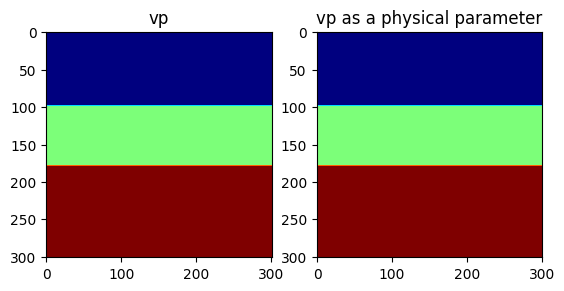

PyObject Text(0.5, 1.0, 'vp as a physical parameter')

In [4]:
figure()
subplot(121)
imshow(vp', cmap="jet")
title("vp")
subplot(122)
imshow(VP', cmap="jet")
title("vp as a physical parameter")

Because the physical parameter behaves as vector, we can easily perform standard operations on it.

In [5]:
norm(VP), extrema(VP), 2f0 .* VP, VP .^ 2

(626.8016f0, (1.5f0, 2.5f0), PhysicalParameter{Float32, 2} of size (301, 301) with origin (0.0f0, 0.0f0) and spacing (10.0f0, 10.0f0), PhysicalParameter{Float32, 2} of size (301, 301) with origin (0.0f0, 0.0f0) and spacing (10.0f0, 10.0f0))

# Model

JUDI then provide a Model structure that wraps multiple physical parameters toghether. A Model accept currently only accept standard Array as an input (to be fixed #1)

In [6]:
model = Model(shape, spacing, origin, 1f0./vp.^2f0; nb = 80)

Model (n=(301, 301), d=(10.0f0, 10.0f0), o=(0.0f0, 0.0f0)) with parameters (:m, :rho)

# Modeling

Now that we have a seismic model, we will generate a few shot records.

# Acquisition Geometry

The first thing we need is an acquisiton geometry. In JUDI there is two ways to create a Geometry.

⋅ By hand, as we will show here  
⋅ From a SEGY file, as we will show in a follow-up tutorial

We create a split-spread geomtry with sources at the top and receivers at the ocean bottom (top of second layer).

##### Note:
JUDI currently expects all three coordinates to be inputed to setup a Geometry in 2D as well. This will be fixed in a later version of JUDI.

In [7]:
# Sources position
nsrc = 11
xsrc = range(0f0, (shape[1] -1)*spacing[1], length=nsrc)
ysrc = 0f0 .* xsrc # this a 2D case so we set y to zero
zsrc = 12.5f0*ones(Float32, nsrc);

Now this definition creates a single Array of position, which would correspond to a single Simultenous source. Since we are interested in single source experiments here, we convert these position into an Array of Array of size nsrc where each sub-array is a single source position

In [8]:
xsrc, ysrc, zsrc = convertToCell.([xsrc, ysrc, zsrc]);

In [9]:
# OBN position
nrec = 101
xrec = range(0f0, (shape[1] -1)*spacing[1], length=nrec)
yrec = 0f0 # this a 2D case so we set y to zero. This can be a single number for receivers
zrec = (2*spacing[1])*ones(Float32, nrec);

The last step to be able to create and acquisiton geometry is to define a recording time and sampling rate

In [10]:
record_time = 3500f0 # Recording time in ms (since we have m/ms for the velocity)
sampling_rate = 4f0; # Let's use a standard 4ms sampling rate

Now we can create the source and receivers geometry

In [11]:
src_geom = Geometry(xsrc, ysrc, zsrc; dt=sampling_rate, t=record_time)
# For the receiver geometry, we specify the number of source to tell JUDI to use the same receiver position for all sources
rec_geom = Geometry(xrec, yrec, zrec, dt=sampling_rate, t=record_time, nsrc=nsrc);

Let's visualize the geometry onto the model

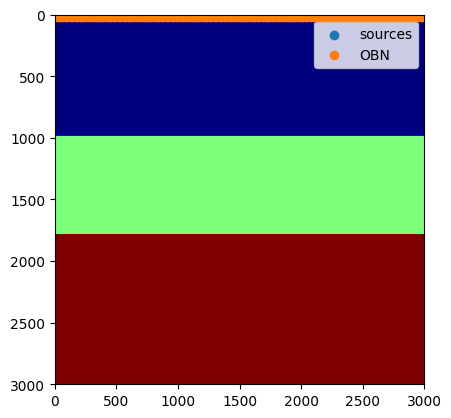

PyObject <matplotlib.legend.Legend object at 0x7fd5d57a0fd0>

In [12]:
figure();
imshow(vp', cmap="jet", extent=[0, (shape[1]-1)*spacing[1], (shape[2]-1)*spacing[2], 0])
scatter(xsrc, zsrc, label=:sources)
scatter(xrec, zrec, label="OBN")
legend()

## Source wavelet


For the source wavelet, we will use a standard Ricker wavelet at 10Hz for this tutorial.In practice this wavelet would be read from a file or estimated during inversion.

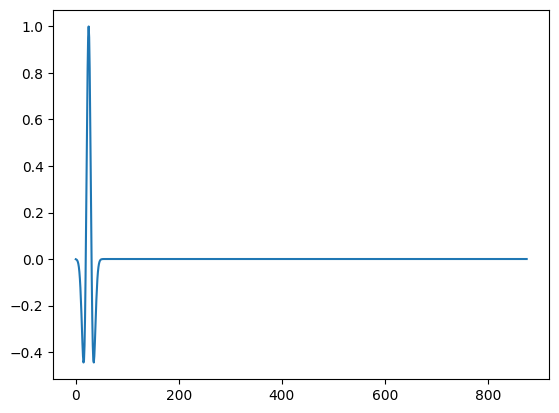

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd5d54c0220>

In [13]:
f0 = 0.010 # Since we use ms, the frequency is in KHz
wavelet = ricker_wavelet(record_time, sampling_rate, f0);
plot(wavelet)

# judiVector

In order to represent seismic data, JUDI provide the judiVector type. This type wraps a geometry with the seismic data corresponding to it. Let's cretae one for the source

In [14]:
q = judiVector(src_geom, wavelet)
opt = Options(IC = "isic", dt_comp=0.7f0);

# Linear operator

The last step to model our seismic data os to create the linear operator representing the discretized wave equation on the Model we defined. We also need to define the linear operator corresponding to the source injection and the receiver interpolation.

In [15]:
Pr = judiProjection(rec_geom) # receiver interpolation
Ps = judiProjection(src_geom) # Source interpolation
Ainv = judiModeling(model;options=opt) # Inverse of the disrete ewave equation.

JUDI forward{Float32} propagator (x * z * time) -> (x * z * time)

WARNING: While these three operator are well defined in JUDI, judiProjection is a no-op operator and cannot be used by itself but only in combination with a judiModeling operator

# Seismic Data Generation

Now that we have all our operators setup we can finally generate synthetic data wit ha simple mat-vec product thanks to the abstraction

In [16]:
d_obs = Pr * Ainv * Ps' * q

Building forward operator
Operator `forward` ran in 0.41 s
Operator `forward` ran in 0.46 s
Operator `forward` ran in 0.49 s
Operator `forward` ran in 0.43 s
Operator `forward` ran in 0.44 s
Operator `forward` ran in 0.41 s
Operator `forward` ran in 0.39 s
Operator `forward` ran in 0.46 s
Operator `forward` ran in 0.40 s
Operator `forward` ran in 0.48 s
Operator `forward` ran in 0.39 s


judiVector{Float32, Matrix{Float32}} with 11 sources


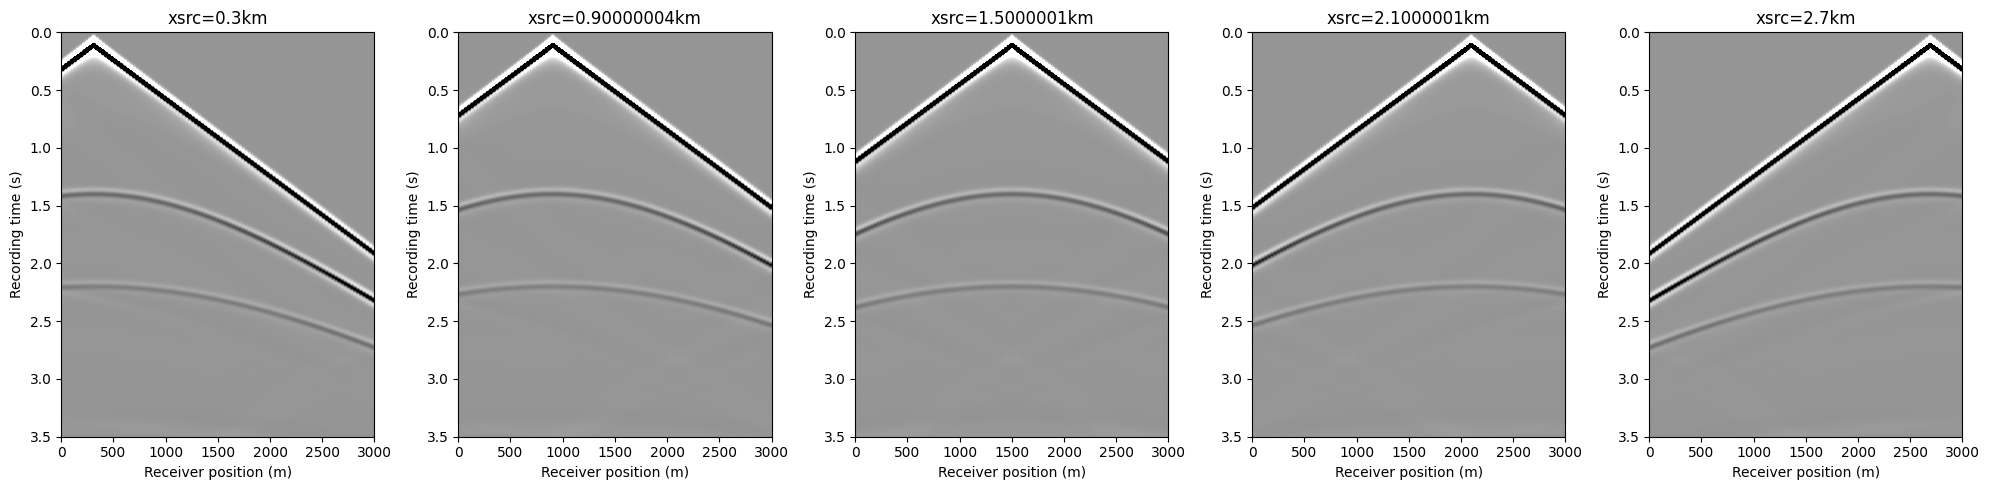

In [17]:
data_extent = [xrec[1], xrec[end], 1f-3*record_time, 0]
figure(figsize=(20, 5))
for i=1:5
    subplot(1, 5, i)
    imshow(d_obs.data[2*i], vmin=-1, vmax=1, cmap="Greys", extent=data_extent, aspect="auto")
    xlabel("Receiver position (m)")
    ylabel("Recording time (s)")
    title("xsrc=$(1f-3xsrc[2*i][1])km")
end
tight_layout()

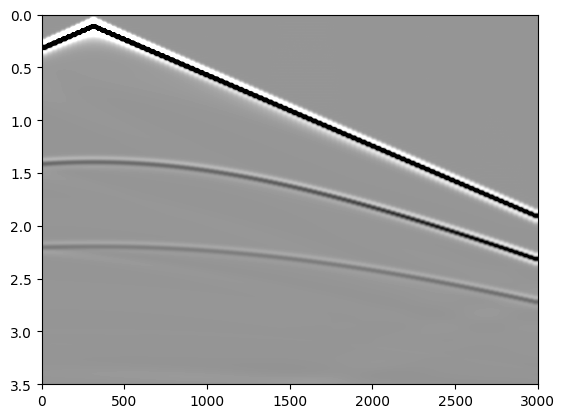

PyObject <matplotlib.image.AxesImage object at 0x7fd5d34c5640>

In [18]:
imshow(d_obs.data[2], vmin=-1, vmax=1, cmap="Greys", extent=data_extent, aspect="auto")

# Elastic simulations (P- and S-waves)

In the acoustic example above, the model is defined only by the *P-wave* velocity (equivalently the squared slowness \(m=1/v_p^2\)).  
For an **elastic** simulation we must also provide a **shear-wave velocity** \(v_s\).

A simple (not unique!) way to build \(v_s\) is:
- **Water layer (top layer):** set \(v_s = 0\) (fluids do not support shear)
- **Solid layers:** set \(v_s \approx v_p/\sqrt{3}\)

In [19]:
# --- Elastic model construction (vp + vs) ---

# "Water bottom" index (top of the second layer). In our toy model this is where vp jumps at depth index 66.
idx_wb = 66

# Shear-wave velocity: vs = 0 in water, vs = vp/sqrt(3) in the solid
vs  = zeros(Float32, shape)
vs[:,  idx_wb:end] .= vp[:,  idx_wb:end] ./ 1.732f0

# Squared slowness (acoustic parameterization uses m = 1/vp^2)
m  = 1f0 ./ vp.^2f0

# Elastic Models: pass vs via keyword argument
model_el  = Model(shape, spacing, origin, m;  vs=vs,  nb=80)

opt_el = Options(IC = "isic", dt_comp=0.7f0);

In [29]:
# --- Elastic modeling operators + data generation ---

Pr_el = judiProjection(rec_geom)
Ps_el = judiProjection(src_geom)

Ainv_el  = judiModeling(model_el;  options=opt_el)

q_el = cumsum(q, dims=1)*sampling_rate

# Elastic synthetic data (true + background)
d_obs_el  = Pr_el * Ainv_el  * Ps_el' * q_el

Operator `forward` ran in 1.80 s
Operator `forward` ran in 1.77 s
Operator `forward` ran in 1.75 s
Operator `forward` ran in 1.77 s
Operator `forward` ran in 1.76 s
Operator `forward` ran in 1.89 s
Operator `forward` ran in 1.81 s
Operator `forward` ran in 1.77 s
Operator `forward` ran in 1.88 s
Operator `forward` ran in 2.01 s
Operator `forward` ran in 2.39 s


judiVector{Float32, Matrix{Float32}} with 11 sources


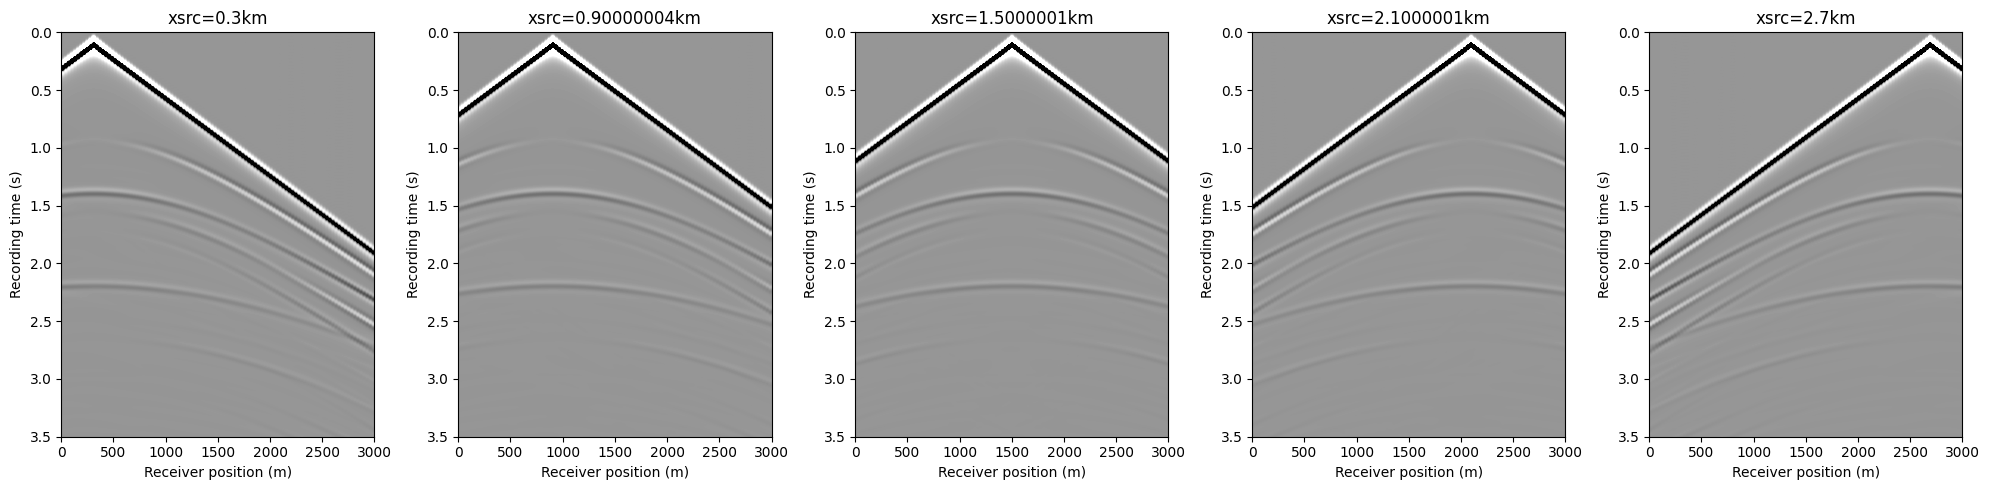

In [30]:
data_extent = [xrec[1], xrec[end], 1f-3*record_time, 0]
figure(figsize=(20, 5))
for i=1:5
    subplot(1, 5, i)
    imshow(d_obs_el.data[2*i], vmin=-1, vmax=1, cmap="Greys", extent=data_extent, aspect="auto")
    xlabel("Receiver position (m)")
    ylabel("Recording time (s)")
    title("xsrc=$(1f-3xsrc[2*i][1])km")
end
tight_layout()

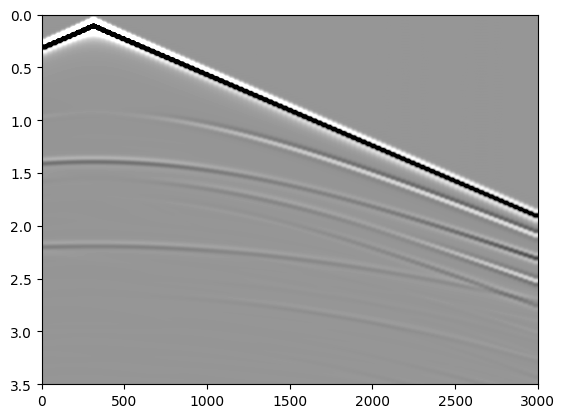

PyObject <matplotlib.image.AxesImage object at 0x7fd5d31a7a30>

In [31]:
imshow(d_obs_el.data[2], vmin=-1, vmax=1, cmap="Greys", extent=data_extent, aspect="auto")

Questions:
1) Can you interpret the differences in the acoustic and elastic events in the plots? Please also explain why are there those differences.
General questions (though not related to about figures but they were used in simulations)
3) Why do we not see shear waves in the water layer?
4) What physical property of fluids explains this?

Now that we have seen how to do seismic modeling, we will see now how to image the Earth using JUDI. 

# Acoustic Imaging
For imaging we need a smooth velocity (background) model, which we can obtain by applying Gaussian smoothing on the origianl model, vp.

In [65]:
vp0 = 1f0./imfilter(1f0./vp, Kernel.gaussian(5))
model0 = Model(shape, spacing, origin, 1f0./vp0.^2f0; nb = 80)
Ainv0 = judiModeling(model0;options=opt)
F0 = Pr * Ainv0 * Ps'
J = judiJacobian(F0, q)

JUDI born{Float32} propagator (z * x) -> (src * rec * time)

In [66]:
d_obs0 = Pr * Ainv0 * Ps' * q

Operator `forward` ran in 0.47 s
Operator `forward` ran in 0.42 s
Operator `forward` ran in 0.39 s
Operator `forward` ran in 0.40 s
Operator `forward` ran in 0.39 s
Operator `forward` ran in 0.39 s
Operator `forward` ran in 0.39 s
Operator `forward` ran in 0.40 s
Operator `forward` ran in 0.42 s
Operator `forward` ran in 0.39 s
Operator `forward` ran in 0.53 s


judiVector{Float32, Matrix{Float32}} with 11 sources


In [67]:
img = J'*(d_obs-d_obs0);

Operator `forward` ran in 0.45 s
Operator `gradient` ran in 1.05 s
Operator `forward` ran in 0.42 s
Operator `gradient` ran in 1.02 s
Operator `forward` ran in 0.43 s
Operator `gradient` ran in 1.02 s
Operator `forward` ran in 0.41 s
Operator `gradient` ran in 0.99 s
Operator `forward` ran in 0.41 s
Operator `gradient` ran in 0.99 s
Operator `forward` ran in 0.41 s
Operator `gradient` ran in 0.98 s
Operator `forward` ran in 0.41 s
Operator `gradient` ran in 0.99 s
Operator `forward` ran in 0.42 s
Operator `gradient` ran in 1.11 s
Operator `forward` ran in 0.42 s
Operator `gradient` ran in 0.99 s
Operator `forward` ran in 0.41 s
Operator `gradient` ran in 1.00 s
Operator `forward` ran in 0.41 s
Operator `gradient` ran in 1.00 s


Question:
1) Run the below cell and interpret the shot record (what happens when the velocity is very smooth?)

In [ ]:
imshow(d_obs0.data[2], vmin=-1, vmax=1, cmap="Greys", extent=data_extent, aspect="auto")

In [68]:
img[:,1:20] .= 0.0f0; # Mute a part of water column to get rid of source-receiver artifacts

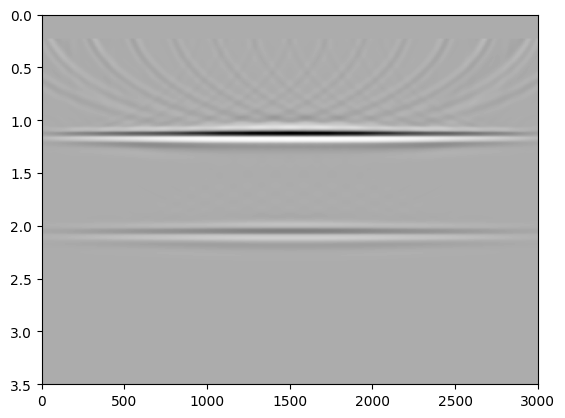

PyObject <matplotlib.image.AxesImage object at 0x7fd4b84275e0>

In [69]:
imshow(img', cmap="Greys", extent=data_extent, aspect="auto")

Question:
1) Taking the motivation from the acoustic imaging, can you perform elastic imaging in the cells below and mention your observations from the elastic image (compared to acoustic)?

# Elastic Imaging

In [56]:
vs0 = 
model0_el = 
Ainv0_el = 

JUDI forward{Float32} propagator (x * z * time) -> (x * z * time)

In [57]:
d_obs0_el = Pr * Ainv0_el * Ps' * q_el

Operator `forward` ran in 2.19 s
Operator `forward` ran in 1.98 s
Operator `forward` ran in 2.22 s
Operator `forward` ran in 1.96 s
Operator `forward` ran in 1.94 s
Operator `forward` ran in 2.24 s
Operator `forward` ran in 2.29 s
Operator `forward` ran in 2.13 s
Operator `forward` ran in 2.38 s
Operator `forward` ran in 2.16 s
Operator `forward` ran in 2.06 s


judiVector{Float32, Matrix{Float32}} with 11 sources


## Important Note: Use the same J (Jacobian) as acosutic here.

In [61]:
img_el = 

Operator `forward` ran in 0.58 s
Operator `gradient` ran in 1.32 s
Operator `forward` ran in 0.48 s
Operator `gradient` ran in 1.01 s
Operator `forward` ran in 0.42 s
Operator `gradient` ran in 0.99 s
Operator `forward` ran in 0.49 s
Operator `gradient` ran in 1.04 s
Operator `forward` ran in 0.46 s
Operator `gradient` ran in 1.01 s
Operator `forward` ran in 0.48 s
Operator `gradient` ran in 1.24 s
Operator `forward` ran in 0.42 s
Operator `gradient` ran in 1.06 s
Operator `forward` ran in 0.44 s
Operator `gradient` ran in 1.00 s
Operator `forward` ran in 0.42 s
Operator `gradient` ran in 1.00 s
Operator `forward` ran in 0.51 s
Operator `gradient` ran in 1.01 s
Operator `forward` ran in 0.53 s
Operator `gradient` ran in 1.31 s


In [62]:
img_el[:,1:20] .= 0.0f0; # Mute a part of water column to get rid of source-receiver artifacts

In [ ]:
imshow(img_el', cmap="Greys", extent=data_extent, aspect="auto")

Question:
1) Please repeat the same experiments (elastic and acoustic) for the case where the lower layer is slanting instead of horizontal and interpret the differences compared to the above experiments.